In [1]:
# To prepare a transfer learning based binary classifier using the pre-trained VGG16.

from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, History
import random
import os
import cv2
import matplotlib.pyplot as plt

In [11]:
TRAIN_SPLIT = 0.80

DIR = ''

In [12]:
def main():
	#original_model_prediction()
	
	# Prepare data sets
	imgH = 128; imgW = 128 
	trainX, trainY, testX, testY = preprocess_data(imgH, imgW)
	
	# Train and save model.
	modelPath = DIR + 'VGG_BinaryClassifier.hdf5'
	training(trainX, trainY, modelPath, imgH, imgW)
	
	# Load and test the model
	testing(testX, testY, modelPath)

In [13]:
def testing(testX, testY, modelPath):
	# Preprocess image data to be fit with VGG16
	testXX = preprocess_input(testX) 
	
	# Load the trained model'
	model = load_model(modelPath)
	
	# Predict Class
	predictions = model.predict(testX)
	predictedClass = ['SmartPhone' if a < 0.5 else 'ButtonPhone' for a in predictions] 
	actualClass = ['SmartPhone' if a < 0.5 else 'ButtonPhone' for a in testY]	
	print('Actual Class: {}'.format(actualClass))
	print('Predicted Class: {}'.format(predictedClass))
	display_images_with_predictions(testX, predictedClass)
	
	# Evaluate model performance
	model.compile(metrics = 'accuracy')
	loss, accuracy = model.evaluate(testXX, testY)
	print('Accuracy: {}'.format(accuracy))

In [14]:
def training(trainX, trainY, modelPath, imgH, imgW):
	# Preprocess image data to be fit with VGG16
	print(trainX.max(), trainX.min())
	trainX = preprocess_input(trainX)
	print(trainX.max(), trainX.min())
		
	# Build model architecture. 
	model = build_model(imgH, imgW)
	
	# Train model
	model.compile(loss = 'mse', optimizer = 'rmsprop')
	callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10), History()]
	history = model.fit(trainX, trainY, epochs = 100, batch_size = 32, validation_split = 0.2, callbacks = callbackList)
		
	# Save trained model and figure of training and validation loss.
	model.save(modelPath)
	figPath = DIR + 'Training_Vs_Val_Loss.png'
	plot_loss(history, figPath)
	

In [15]:
def plot_loss(history, figPath):
	loss = history.history['loss']
	valLoss = history.history['val_loss']
	epochs = range(1, len(loss) + 1)

	plt.figure(figsize = (20, 20))
	plt.rcParams['font.size'] = '14'
	plt.plot(epochs, loss, 'bo-', label = 'Training loss')
	plt.plot(epochs, valLoss, 'k*-', label = 'Validation loss')
	plt.title('Training and validation loss')
	plt.legend()
	
	plt.savefig(figPath)
	plt.close()

In [16]:
def display_images_with_predictions(imgSet, labelSet):
	plt.figure(figsize = (20, 20))
	for i in range(9):
		plt.subplot(3, 3, i + 1)
		plt.title(labelSet[i])
		plt.imshow(imgSet[i])
		plt.axis('off')
	plt.show()
	

In [17]:
def preprocess_data(imgW, imgH):
	# Load image data
	imgDir = DIR + 'SmartPhone/'
	imgSet1 = prepare_image_array(imgDir, imgW, imgH)
	print(imgSet1.shape)
	m = imgSet1.shape[0]
	
	imgDir = DIR + 'ButtonPhone/'
	imgSet2 = prepare_image_array(imgDir, imgW, imgH)
	print(imgSet2.shape)
	n = imgSet2.shape[0]
	
	# Put all image data into one array.
	imgSet = np.concatenate((imgSet1, imgSet2), axis = 0)
	print(imgSet.shape)
	
	# Prepare labels.
	labelSet1 = np.zeros(m, dtype = np.uint8)
	labelSet2 = np.ones(n, dtype = np.uint8)
	labelSet = np.concatenate((labelSet1, labelSet2), axis = 0)
	print(labelSet)
	
	# Shuffle image data and labels
	p = imgSet.shape[0] # p = n + m
	indices = np.arange(p)
	print(indices)
	random.shuffle(indices)
	print(indices)	
	imgSet = imgSet[indices]
	labelSet = labelSet[indices]
	
	# Split data into training and test sets
	r = int(p * TRAIN_SPLIT)
	trainX = imgSet[:r]
	trainY = labelSet[:r]
	testX = imgSet[r:]
	testY = labelSet[r:]
	
	return trainX, trainY, testX, testY

def prepare_image_array(imgDir, imgW, imgH):
	imgList = os.listdir(imgDir)
	#print(imgList)
	n = len(imgList)
	
	imgSet = []
	for i in range(n):
		imgPath = imgDir + imgList[i]
		if (os.path.exists(imgPath)):
			print(imgPath)
			
			# Load image.
			img = cv2.imread(imgPath)
			print(img.shape)
			
			# Resize image.
			resizedImg = cv2.resize(img, (imgW, imgH))
			print(resizedImg.shape)
			
			# Convert BGR image into RGB image.
			rgbImg = cv2.cvtColor(resizedImg, cv2.COLOR_BGR2RGB)
			
			# Put image into a list
			imgSet.append(rgbImg)
		else:
			print("It is not a valid image path.")
		
	print(len(imgSet))
	imgSet = np.array(imgSet, dtype = np.uint8)
	print(imgSet.shape)
	
	return imgSet

In [18]:
def build_model(imgH, imgW):
	baseModel = VGG16(input_shape = (imgH, imgW, 3), include_top = False) 
	baseModel.summary()
	
	for layer in baseModel.layers:
		layer.trainable = False
	baseModel.summary()
	
	inputs = baseModel.input
	x = baseModel.output
	x = Flatten()(x)
	x = Dense(32, activation = 'sigmoid')(x)
	x = Dense(8, activation = 'sigmoid')(x)
	outputs = Dense(1, activation = 'sigmoid')(x)
	
	model = Model(inputs, outputs)
	model.summary()
	
	return model

SmartPhone/210.jpg
(2195, 3701, 3)
(128, 128, 3)
SmartPhone/55243435.jpg
(450, 800, 3)
(128, 128, 3)
SmartPhone/61Lpcw+nv1L._AC_SX522_.jpg
(620, 522, 3)
(128, 128, 3)
SmartPhone/61pP6pemX3L._AC_SX679_.jpg
(826, 679, 3)
(128, 128, 3)
SmartPhone/71vq85GMg0L._AC_SL1500_.jpg
(1014, 1500, 3)
(128, 128, 3)
SmartPhone/71w15n3u09L._AC_SX679_.jpg
(490, 679, 3)
(128, 128, 3)
SmartPhone/81NKXayE47L._AC_SX679_.jpg
(730, 679, 3)
(128, 128, 3)
SmartPhone/download.jpg
(325, 155, 3)
(128, 128, 3)
SmartPhone/images.jpg
(187, 269, 3)
(128, 128, 3)
SmartPhone/jbar0.jpg
(800, 1200, 3)
(128, 128, 3)
SmartPhone/jpig.jpg
(900, 1200, 3)
(128, 128, 3)
SmartPhone/Original-Unlocke.jpg
(1280, 1280, 3)
(128, 128, 3)
SmartPhone/photb618.jpg
(1500, 1000, 3)
(128, 128, 3)
SmartPhone/S20-FE_Navy_SKUimage_MO_img.jpg
(720, 720, 3)
(128, 128, 3)
SmartPhone/Samsung_Galiew_05.jpg
(800, 1200, 3)
(128, 128, 3)
SmartPhone/saphone.jpg
(600, 600, 3)
(128, 128, 3)
SmartPhone/sg-7.jpg
(2000, 3000, 3)
(128, 128, 3)
SmartPhone/Smar

1/1 [==============================] - 3s 3s/step - loss: 0.4184 - val_loss: 0.3258
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.2865 - val_loss: 0.3085
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.2716 - val_loss: 0.2885
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.2563 - val_loss: 0.2708
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.2487 - val_loss: 0.2656
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.2440 - val_loss: 0.2618
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.2398 - val_loss: 0.2564
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 0.2355 - val_loss: 0.2529
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 0.2323 - val_loss: 0.2496
Epoch 10/100
1/1 [==============================] - 2s 2s/step - loss: 0.2293 - val_loss: 0.2468
Epoch 11/100
1/1 [==============================] -

1/1 [==============================] - 2s 2s/step - loss: 0.1205 - val_loss: 0.1330
Epoch 86/100
1/1 [==============================] - 2s 2s/step - loss: 0.1197 - val_loss: 0.1321
Epoch 87/100
1/1 [==============================] - 2s 2s/step - loss: 0.1189 - val_loss: 0.1313
Epoch 88/100
1/1 [==============================] - 2s 2s/step - loss: 0.1181 - val_loss: 0.1304
Epoch 89/100
1/1 [==============================] - 2s 2s/step - loss: 0.1173 - val_loss: 0.1295
Epoch 90/100
1/1 [==============================] - 2s 2s/step - loss: 0.1165 - val_loss: 0.1287
Epoch 91/100
1/1 [==============================] - 2s 2s/step - loss: 0.1157 - val_loss: 0.1278
Epoch 92/100
1/1 [==============================] - 2s 2s/step - loss: 0.1149 - val_loss: 0.1270
Epoch 93/100
1/1 [==============================] - 2s 2s/step - loss: 0.1142 - val_loss: 0.1261
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 0.1134 - val_loss: 0.1253
Epoch 95/100
1/1 [=========================

IndexError: list index out of range

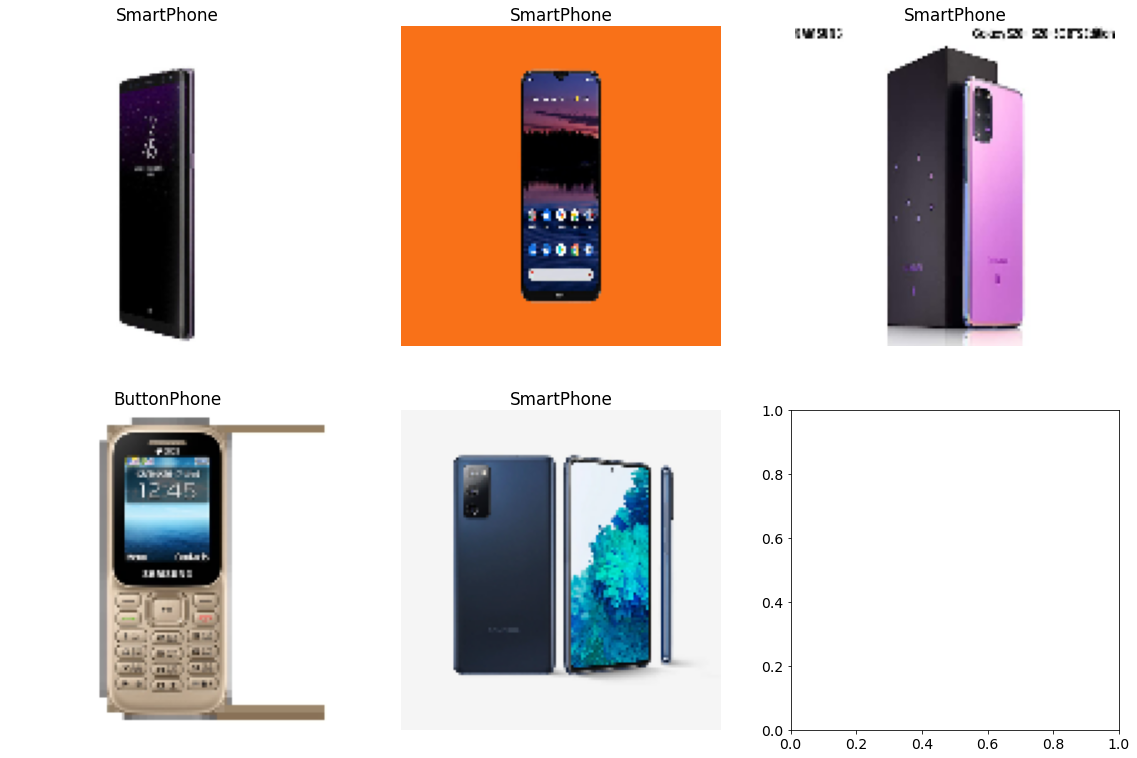

In [19]:
if __name__ == '__main__':
	main()